In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# European Data Cleaner

## Load Data Sets

In [16]:
# Location of the file
location = r'/home/leo/Sciebo/Power-Grid Frequency Data/Germany/2016/'
# Year
year = r'2016'
# Month
month = r'01'
# File name
file_name = year + month + r'_Frequenz.csv'
df = pd.read_csv(location + file_name, sep=',',header=None)

# A readme file is created with each process, to keep track
# of the changes applied to the data.
readme = 'data/Readme_' + year + '_' + month + '.txt'

#opens readme file
f = open(readme,'a+')

Dates=df[0].values
#Times=df[1].values

# Here we remove 50 Hz from the frequency, since it is
# common to work in a reference frame where the nominal
# frequency is 0 Hz (useful to compare US and EU data) 
data=df[3].values - 50.0  # 60.0 for US and Japan

## Checking length of data

In [17]:
with open(readme,'a+') as f:
    print(r'Days recorded are integers?',file=f)
    print((data.size/86400).is_integer(), file=f)
    if (data.size/86400).is_integer() == False:
        print(r' -- Check if it was a month with daylight savings? --', file=f)
    print(r'How many days?', file=f)
    print((data.size/86400), file=f)
    print(r'Starting date is?', file=f)
    print(Dates[0], file=f)
    print(r'Ending date is?', file=f)
    print(Dates[-1], file=f)
    print(r'  ')
    print(r'List days in the recording', file=f)
    print([Dates[::86400][j][-2:] for j in range(Dates[::86400].size)], file=f)

### If data extends beyond a month's period

In [18]:
# by setting the truncation to remove undesired days. Say  the data includes 12
# days of the previous month: set truncation_start = 12
truncation_start = 0
if truncation_start != 0: df=df[:][86400*truncation_start:]

# in case the data extends, for example, 5 days after the end of the month, set
# here the truncation to 5 (truncation_end = 5)
truncation_end = 0
if truncation_end != 0: df=df[:][:-86400*truncation_end]

## Clean dead recordings (<48.1 or >51.9 hz)

In [19]:
# any recording smaller than 48.1Hz or larger than 51.9Hz
# are assigned 50Hz (i.e. 0.0 in our reference)
with open(readme,'a+') as f:
    print(r'there are ' + str(data[data<-1.9].size) + r' recordings with <48Hz', file=f)
    print(r'there are ' + str(data[data>1.9].size) + r' recordings with >52Hz', file=f)
data[data<-1.9]=0.
data[data>2.]=0.

## Find plateaus on the data

In [20]:
# This part of the code detects any plateaus of a
# timespan longer than 20 seconds. I does not alter
# the value of the frequency, but it records the 
# length on the readme file. This is the easiest 
# way to find out how corrupted/useful the data
# is.

diff=np.diff(data)
loc=np.array([])
dead=np.zeros([20])
for i in range(3,diff.size):
    if np.array_equal(diff[i-10:i+10],dead) == True:
        loc = np.append(loc,i)

loc_of_trouble = np.nonzero(np.diff(loc)-1)[0]     
if loc_of_trouble.size > 0:

    num_of_trouble = loc_of_trouble.size + 1
    with open(readme,'a+') as f:
        print('There are '+str(np.nonzero(np.diff(loc)-1)[0].size + 1) + ' locations with plateaus of 20 seconds or longer', file=f)
        for i in range(num_of_trouble-1 ):
            print('Plateau [' + str(i+1) + '] totaling '+str(loc_of_trouble[i] + 21) + ' seconds', file=f)
        print('Plateau [' + str(num_of_trouble) + '] totaling '+str(loc.size-loc_of_trouble[num_of_trouble-2] + 19) + ' seconds', file=f)    
elif loc_of_trouble.size == 0: 
    with open(readme,'a+') as f:
        print('There are no plateaus of 20 seconds or longer', file=f)


## Clean sudden variations of the frequency

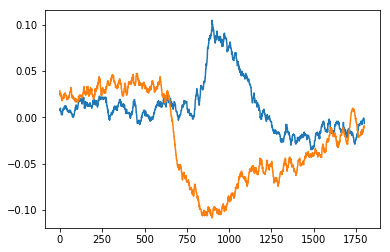

In [21]:
# This part of the code checks for sudden large-value
# fluctuations of the frequency. Any form of peaks and
# miss-measurements should show up here. The value of 
# those recording are set to the value 5 seconds before.
# (this is an empirical choise that has worked well so
# far). It leaves a report on the readme file as well

eliminate=np.argsort(np.diff(data))
i=0
while np.diff(data)[eliminate[i]] < - 0.0075:
    i=i+1

lower_lim=i+1
with open(readme,'a+') as f:
    print('There are '+str(lower_lim)+' low frequency jumps', file=f)


i=1
while np.diff(data)[eliminate[-i]] > 0.0075:
    i=i+1

upper_lim=data.size - i -1
with open(readme,'a+') as f:
    print('There are '+str(data.size-upper_lim)+' high frequency jumps', file=f)

data[eliminate[:lower_lim]]=data[eliminate[:lower_lim]-5]
data[eliminate[upper_lim:]]=data[eliminate[upper_lim:]-5]

# This is the final plot, that simply searches for the 
# extrema of the results. If the plots shows no sharp 
# peaks, the data should be clean.

plt.plot(data[np.argmax(data)-900:np.argmax(data)+900])
plt.plot(data[np.argmin(data)-900:np.argmin(data)+900])

## Record data in txt and npz

In [22]:
# This records the data in three formats: npz for numpy,
# txt, and csv. The CSV files are stored again in the 
# 50 (60) Hz to match the format by the providers, in case
# you would like to share/send the data to someone else

np.savez_compressed('data/2016_' + str(month),data=data)
np.savetxt('data/2016_' + str(month) + '.txt',data)
df[3] = data+50.  # 60. for US and Japan
dfs=df[[0,1,3]]
dfs.to_csv('data/2016_' + str(month) + '.csv',header=None)

# TransNet BW data processor 

## Actual Generation per Production Type

In [21]:
file_name = r'FILE_NAME_AND_LOCATION.csv'

# Read file name
df=pd.read_csv(file_name, sep=',')

In [32]:
# Generates new file with the data compactifying under equivalent categories 
dfs=pd.DataFrame(columns=['Date', 'Time', 'Fossil', 'Nuclear','Wind' , 'Solar', 'Hydro', 'Biomass', 'Geothermal','Total'])

# Record date and times on the new dataframe
dfs['Date']=[df[r'MTU'].values[i][:10] for i in range(df['MTU'].values.size)]
dfs['Time']=[df[r'MTU'].values[i][11:16] for i in range(df['MTU'].values.size)]

# The desired new definition for the new dataframe
Fossil = ['Fossil', 3,4,5,6,7]
Nuclear = ['Nuclear',16]
Wind = ['Wind', 21,22]
Solar = ['Solar',19]
Hydro = ['Hydro',11,12,13,14]
Biomass = ['Biomass',2]
Geothermal = ['Geothermal',10]

# A possible total power consumption
Total = ['Total',2,3,4,5,6,7,10,11,12,13,14,16,17,18,19,20,21,22]

# Add the elements you would like to have on your
# new database here
list_of_elements = [Fossil, Nuclear, Wind, Solar, Hydro, Biomass, Geothermal, Total]

# Interates the elements into a new database dfs
for i in range(len(list_of_elements)):
    dfs[list_of_elements[i][0]] = np.sum(df[df.keys()[list_of_elements[i][1:]]][:].values,axis=1)
